In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from gato import JuegoGato,minimax

In [111]:
juego=JuegoGato([0,0,0,0,0,0,0,0,0],1)
secuencia=[]
secuencias=[]
minimax(juego,1,secuencia,secuencias)

[0, 0]

In [112]:
len(secuencias)

255168

In [113]:
print(secuencias[0])

([0, 1, 2, 3, 4, 5, 6], 1)


In [254]:
episodios=[]
for i in range(len(secuencias)):
    juego=JuegoGato([0]*9,turno=1)
    episodio=[]
    for j in range(len(secuencias[i][0])):
        jugada=secuencias[i][0][j]
        tablero=juego.tablero.copy()
        turno=juego.jugador
        juego.jugar(jugada)
        tablero_siguiente=juego.tablero.copy()
        turno_siguiente=juego.jugador
        juego.evaluar()
        if juego.ganador:
            step=[tablero,turno,jugada,tablero_siguiente,turno_siguiente,juego.ganador,1]
        else:
            step=[tablero,turno,jugada,tablero_siguiente,turno_siguiente,0,0]
        episodio.append(step)
    episodios.append(episodio)

In [259]:
S={}
for episodio in episodios:
    for step in episodio:
        s=(tuple(step[0]),step[1])
        if s in S:
            S[s]+=1
        else:
            S[s]=1
        s=(tuple(step[3]),step[4])
        if s in S:
            S[s]+=1
        else:
            S[s]=1

In [260]:
len(S.keys())

5478

In [261]:
S

{((0, 0, 0, 0, 0, 0, 0, 0, 0), 1): 255168,
 ((1, 0, 0, 0, 0, 0, 0, 0, 0), -1): 55464,
 ((1, -1, 0, 0, 0, 0, 0, 0, 0), 1): 7336,
 ((1, -1, 1, 0, 0, 0, 0, 0, 0), -1): 2368,
 ((1, -1, 1, -1, 0, 0, 0, 0, 0), 1): 816,
 ((1, -1, 1, -1, 1, 0, 0, 0, 0), -1): 432,
 ((1, -1, 1, -1, 1, -1, 0, 0, 0), 1): 288,
 ((1, -1, 1, -1, 1, -1, 1, 0, 0), -1): 108,
 ((1, -1, 1, -1, 1, -1, 0, 1, 0), -1): 576,
 ((1, -1, 1, -1, 1, -1, -1, 1, 0), 1): 1152,
 ((1, -1, 1, -1, 1, -1, -1, 1, 1), -1): 1728,
 ((1, -1, 1, -1, 1, -1, 0, 1, -1), 1): 1152,
 ((1, -1, 1, -1, 1, -1, 1, 1, -1), -1): 1728,
 ((1, -1, 1, -1, 1, -1, 0, 0, 1), -1): 108,
 ((1, -1, 1, -1, 1, 0, -1, 0, 0), 1): 360,
 ((1, -1, 1, -1, 1, 1, -1, 0, 0), -1): 576,
 ((1, -1, 1, -1, 1, 1, -1, -1, 0), 1): 1152,
 ((1, -1, 1, -1, 1, 1, -1, -1, 1), -1): 576,
 ((1, -1, 1, -1, 1, 1, -1, 0, -1), 1): 1152,
 ((1, -1, 1, -1, 1, 1, -1, 1, -1), -1): 2880,
 ((1, -1, 1, -1, 1, 0, -1, 1, 0), -1): 576,
 ((1, -1, 1, -1, 1, 0, -1, 1, -1), 1): 1152,
 ((1, -1, 1, -1, 1, 0, -1, 0, 

In [336]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Input
from keras.optimizers import Adam
from keras.losses import mean_squared_error

In [381]:
seed=12122008
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [382]:
batch_size=64
gamma=0.95
optimizer=Adam(learning_rate=1e-3)
model=Sequential()
model.add(Input(shape=(10,)))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(9))
x=[]
y=[]
for epoch in range(40):
    indices=np.random.randint(len(episodios),size=batch_size)
    batch=[episodios[i] for i in indices]
    states=[]
    actions=[]
    rewards=[]
    next_states=[]
    dones=[]
    for sample in batch:
        for step in sample:
            s_t=step[0].copy()
            s_t.append(step[1])
            states.append(s_t)
            actions.append(tf.one_hot(step[2],9).numpy())
            s_t_1=step[3].copy()
            s_t_1.append(step[4])
            next_states.append(s_t_1)
            rewards.append(step[5])
            dones.append(step[6])
    states=np.asarray(states)
    actions=np.asarray(actions)
    rewards=np.asarray(rewards).reshape(-1,1)
    next_states=np.asarray(next_states)
    dones=np.asarray(dones).reshape(-1,1)

    next_Q=model.predict(next_states)
    max_next_Q=np.max(next_Q,axis=1)
    target_Q=(rewards+(1-dones)*gamma*max_next_Q)
    with tf.GradientTape() as tape:
        raw_Q=model(states)
        Q=tf.reduce_sum(raw_Q*actions,axis=1,keepdims=True)
        loss=tf.reduce_mean(mean_squared_error(target_Q,Q))
        x.append(epoch)
        y.append(loss.numpy())
    grads=tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
17/17 ━━━━━━━━━━━

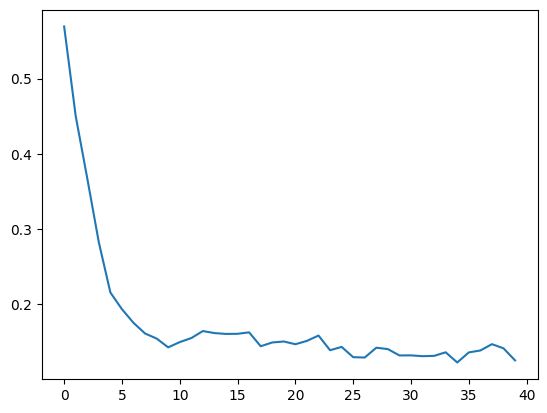

In [383]:
plt.plot(x,y)

In [384]:
test=np.asarray([[1,1,0,-1,1,-1,-1,0,-1,1]])
model.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[0.251, 0.492, 0.458, 0.664, 0.174, 0.319, 0.453, 0.238, 0.493]], dtype=float32)

In [386]:
test=np.asarray([[0,0,0,0,0,0,0,0,0,1]])
np.argmax(model.predict(test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


6